#                                                        **IA for HumanForYou** 
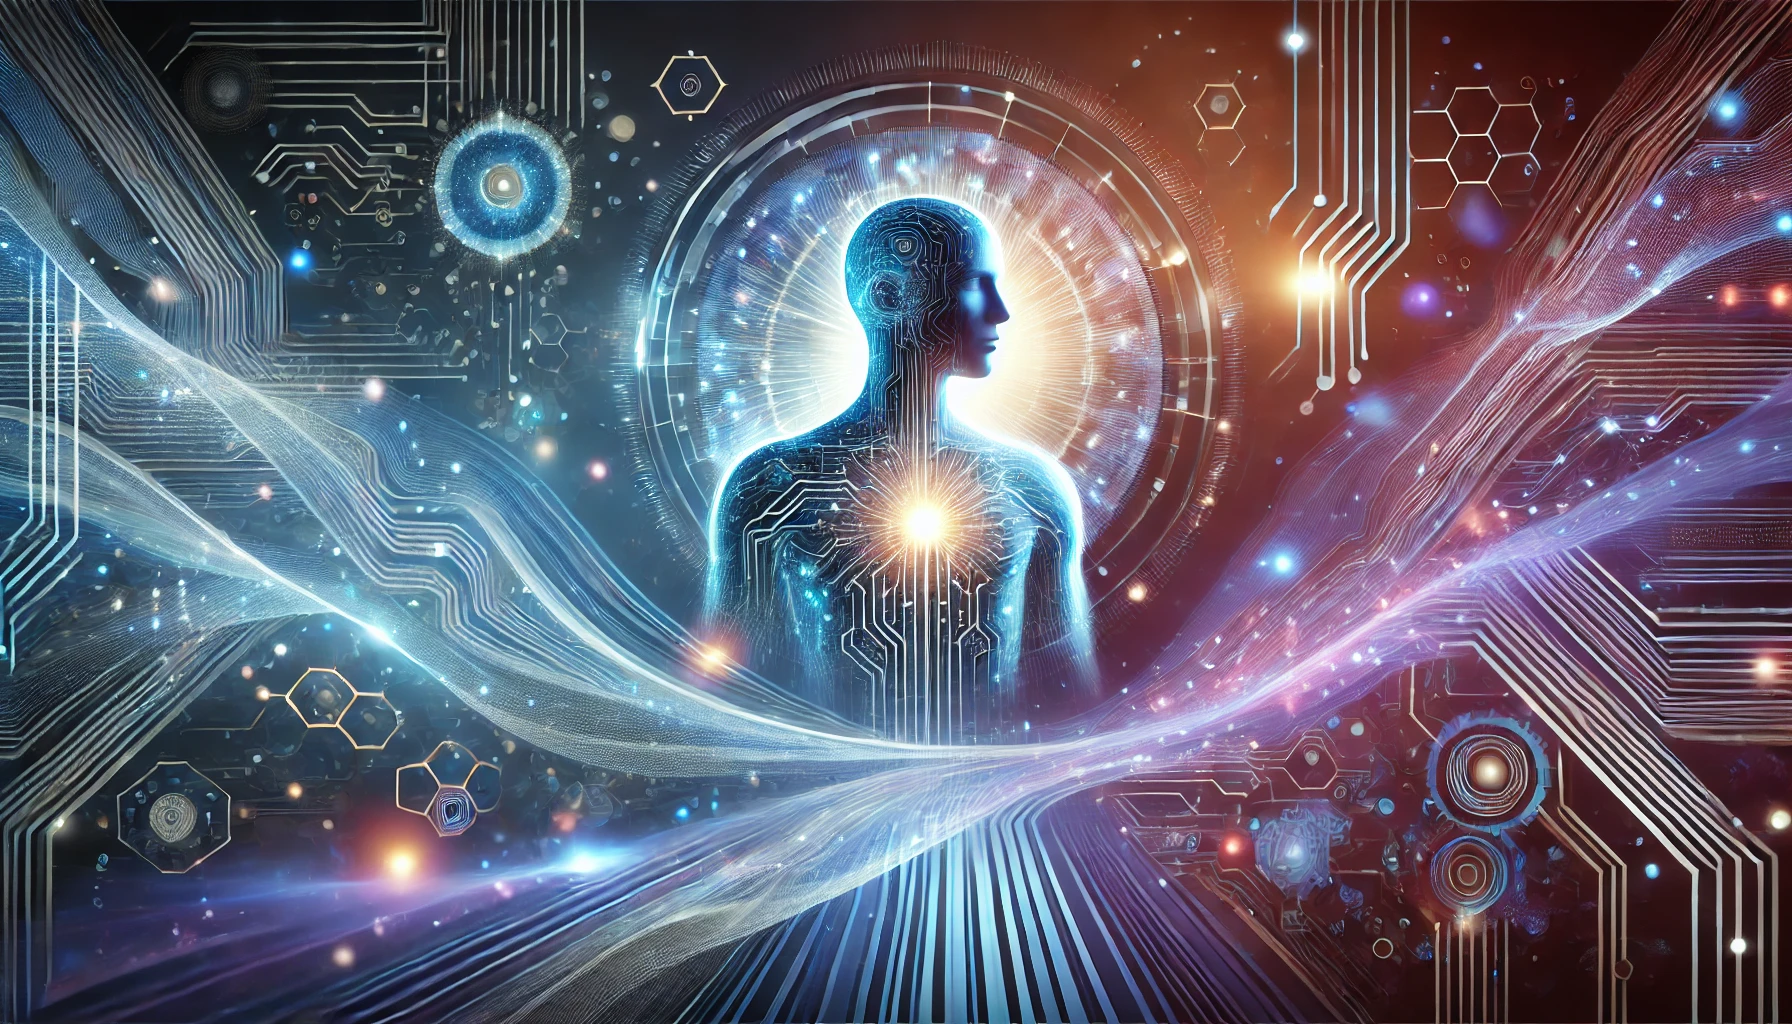

## Plan d'action

1. Importation des bibliothèques
2. Récupération des données
3. Vérification de la cohérence des données
4. Traitement des données manquantes
5. Analyse exploratoire des données
6. Analyse Univariée
7. Analyse Bivariée
8. Étude comparative des différents modèles

## 1. Importation des bibliothèques


In [69]:
from DataExtractor.CSVExtractor import *
from Analysis.Structure import *
from Analysis.MissingData import *
from Analysis.Describe import *
from Normalization.Smithy import *
from Analysis.GraphicsDecriber import *
from Normalization.Imputation import *
from Normalization.Imbalance import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Récupération des données

### **2.1 Liste des fichiers à fournir**

* **general_data.csv :** Informations démographiques et de base sur l’employé (âge, salaire, ancienneté, etc.), ainsi que l’indicateur d’attrition.
* **manager_survey_data.csv :** Évaluations du manager (JobInvolvement, PerformanceRating).
* **employee_survey_data.csv :** Notes de satisfaction des employés (EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance), avec potentiellement des valeurs manquantes (NA).
* **in_out_time.zip :** Données d’horaires d’entrée et de sortie par jour, permettant de calculer le temps de travail effectif, l’absentéisme, etc.
    * **in_time.csv :** Données d’horaires d’entrée par jour.
    * **out_time.csv :** Données d’horaires de sortie par jour.

### **2.2 Chargement des données**

In [70]:
try:
    general_df = create_dataframe("data/general_data.csv")
    manager_df = create_dataframe("data/manager_survey_data.csv")
    employee_df = create_dataframe("data/employee_survey_data.csv")
    in_time_df = create_dataframe("data/in_time.csv")
    out_time_df = create_dataframe("data/out_time.csv")
except Exception as e:
    print(e)
    exit()

## 3. Vérification de la cohérence des données

### **3.1 Échantillons de données**

In [71]:
display_df(general_df,"General Data")
display_df(manager_df,"Manager Data")
display_df(employee_df,"Employee Data")
display_df(in_time_df,"In time Data")
display_df(out_time_df,"Out time Data")

-------------------------------------------
 General Data 
-------------------------------------------
      Age Attrition  ... YearsSinceLastPromotion YearsWithCurrManager
0      51        No  ...                       0                    0
1      31       Yes  ...                       1                    4
...   ...       ...  ...                     ...                  ...
4408   42        No  ...                       7                    8
4409   40        No  ...                       3                    9

[4410 rows x 24 columns]
-------------------------------------------
 Manager Data 
-------------------------------------------
      EmployeeID  JobInvolvement  PerformanceRating
0              1               3                  3
1              2               2                  4
...          ...             ...                ...
4408        4409               2                  3
4409        4410               4                  3

[4410 rows x 3 columns]
-----------

### **3.2 Comprendre la structure et les variables**

In [72]:
visualize_structure(general_df, "General Data")
visualize_structure(manager_df, "Manager Data")
visualize_structure(employee_df, "Employee Data")
visualize_structure(in_time_df, "In time Data")
visualize_structure(out_time_df, "Out time Data")


-------------------------------------------
 General Data 
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410


***Identification des variables cibles et explicatives :***

* **Variable cible (dépendante)** : Attrition (Yes/No).
C’est sur cette variable que vous centrerez votre analyse et vos modèles prédictifs.

* **Variables explicatives (indépendantes) :**
Il s’agit de l’ensemble des autres variables susceptibles d’influencer l’attrition. Parmi les plus importantes, on peut citer :

* **Facteurs démographiques :** Age, Gender, MaritalStatus, Education, EducationField.
* **Facteurs professionnels :** JobRole, JobLevel, Department, TotalWorkingYears, YearsAtCompany, YearsSinceLastPromotion, YearsWithCurrManager, NumCompaniesWorked.
* **Facteurs financiers :** MonthlyIncome, PercentSalaryHike, StockOptionLevel.
* **Facteurs liés à la satisfaction et la performance :** JobInvolvement, PerformanceRating (manager_survey_data), EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance (employee_survey_data).
* **Facteurs liés aux conditions de travail :** calculés à partir de in_time et out_time (heures de travail journalières, absentéisme, etc.).

***Variables à ignorer ou retraiter :***

* EmployeeCount, Over18, StandardHours sont probablement constants ou peu informatifs.
* Vous devrez également décider comment gérer les valeurs manquantes (ex. dans EnvironmentSatisfaction ou WorkLifeBalance).

### **3.3 Vérification de la cohérence et du lien entre les datasets**

In [73]:
print("Nombre d'employés dans general_data :", nb_unqiue_users(general_df))
print("Nombre d'employés dans manager_survey_data :", nb_unqiue_users(manager_df))
print("Nombre d'employés dans employee_survey_data :", nb_unqiue_users(employee_df))

Nombre d'employés dans general_data : 4410
Nombre d'employés dans manager_survey_data : 4410
Nombre d'employés dans employee_survey_data : 4410


Cette cohérence est très encourageante, car cela signifie que chaque employé présent dans general_data.csv se retrouve dans les autres fichiers (manager et employee surveys). On évite ainsi des problèmes de jointure complexes dus à des employés manquants.

* Concernant les fichiers in_time et out_time :

Il est également indiqué que les données d’horaires contiennent 4410 entrées (lignes) correspondant aux mêmes employés, ce qui maintient la cohérence. Le fait que l’EmployeeID soit présent et non-null dans tous les jeux de données est un point fondamental.

**En conclusion :**
L’ensemble des datasets partage la même clé EmployeeID, avec le même nombre d’employés (4410). Il n’y a pas, a priori, d’employés « orphelins » présents dans un fichier et absents dans un autre. Cette cohérence facilite les futures étapes de fusion (merge) des données et l’analyse globale.

## 4. Traitement des données manquantes

### **4.1 Identification des valeurs manquantes**

In [74]:
textual_missing_data(general_df,"General Data")
textual_missing_data(manager_df,"Manager Data")
textual_missing_data(employee_df,"Employee Data")

Valeurs manquantes dans General Data :
----------------------------
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

Valeurs manquantes dans Manager Data :
----------------------------
EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

Valeurs manquantes dans Employee Data :
-------

Valeurs manquantes dans General Data :
----------------------------


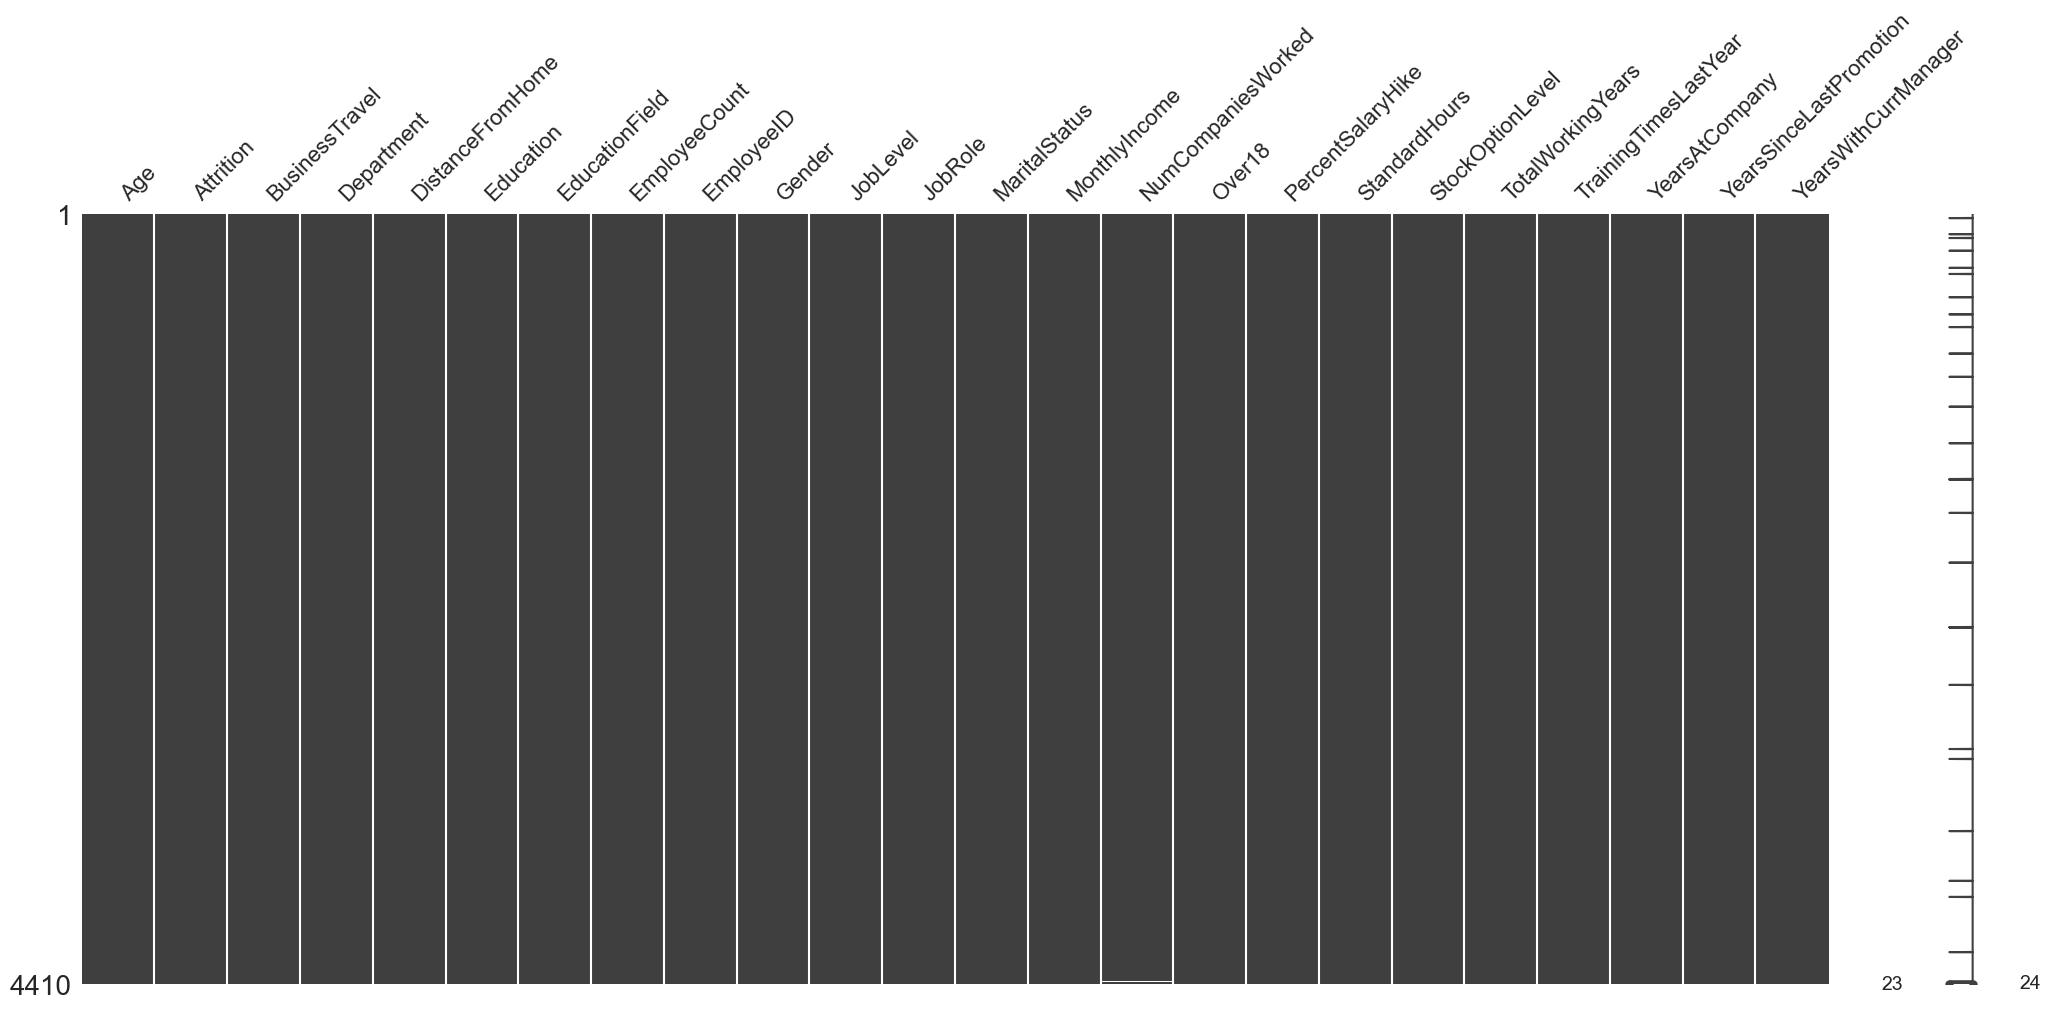

In [75]:
visual_missing_data(general_df,"General Data")

Valeurs manquantes dans Employee Data :
----------------------------


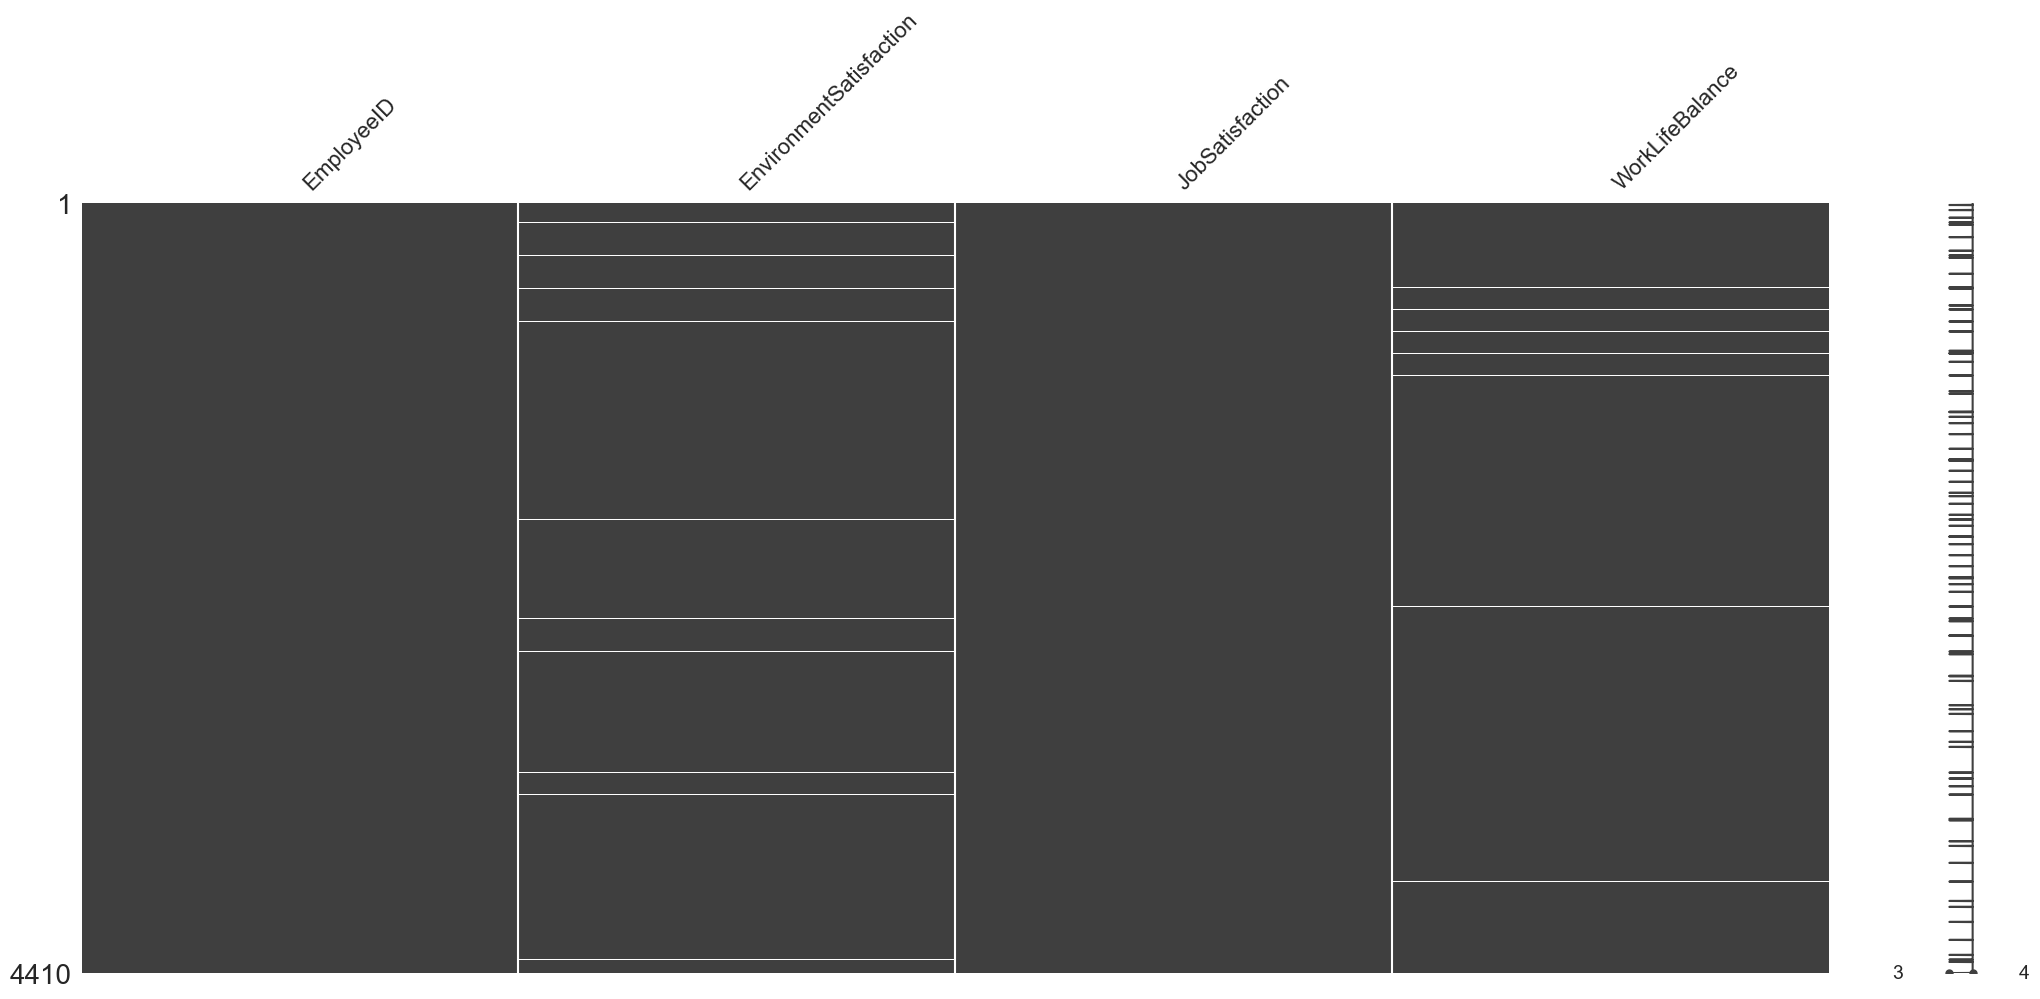

In [76]:
visual_missing_data(employee_df,"Employee Data")

### **4.2 Conclusion sur le manque de données**

**Pour les données du fichier `general_data.csv` :**

* NumCompaniesWorked présente 19 valeurs manquantes.
* TotalWorkingYears présente 9 valeurs manquantes.

**Pour les données du fichier `manager_survey_data.csv` :**

* Aucune valeur manquante.

**Pour les données du fichier `employee_survey_data.csv` :**

* EnvironmentSatisfaction présente 25 valeurs manquantes.
* JobSatisfaction présente 20 valeurs manquantes.
* WorkLifeBalance présente 38 valeurs manquantes.
* EmployeeID est complet, ce qui facilite l’imputation ou la gestion de ces valeurs manquantes.

Les valeurs manquantes identifiées nous informent qu’il faudra faire une étape de nettoyage supplémentaire avant l’analyse exploratoire complète. Les statistiques descriptives devront être calculées après la gestion de ces valeurs manquantes.

### **4.3 Remplacement des données manquantes**

**Pour Variables numériques (ex. NumCompaniesWorked, TotalWorkingYears) :** Remplacer les NA par la médiane

In [77]:
# Imputation des valeurs manquantes dans general_df
# Imputation des valeurs manquantes dans la colonne NumCompaniesWorked
impute_median(general_df, 'NumCompaniesWorked')
# Imputation des valeurs manquantes dans la colonne TotalWorkingYears
impute_median(general_df, 'TotalWorkingYears')

# Imputation des valeurs manquantes dans employee_df
# Imputation des valeurs manquantes dans la colonne EnvironmentSatisfaction
impute_median(employee_df, 'EnvironmentSatisfaction')
# Imputation des valeurs manquantes dans la colonne JobSatisfaction
impute_median(employee_df, 'JobSatisfaction')
# Imputation des valeurs manquantes dans la colonne WorkLifeBalance
impute_median(employee_df, 'WorkLifeBalance')

### **4.4 Vérification d’imputation**

Valeurs manquantes dans General Data :
----------------------------
Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64

Valeurs manquantes dans General Data :
----------------------------


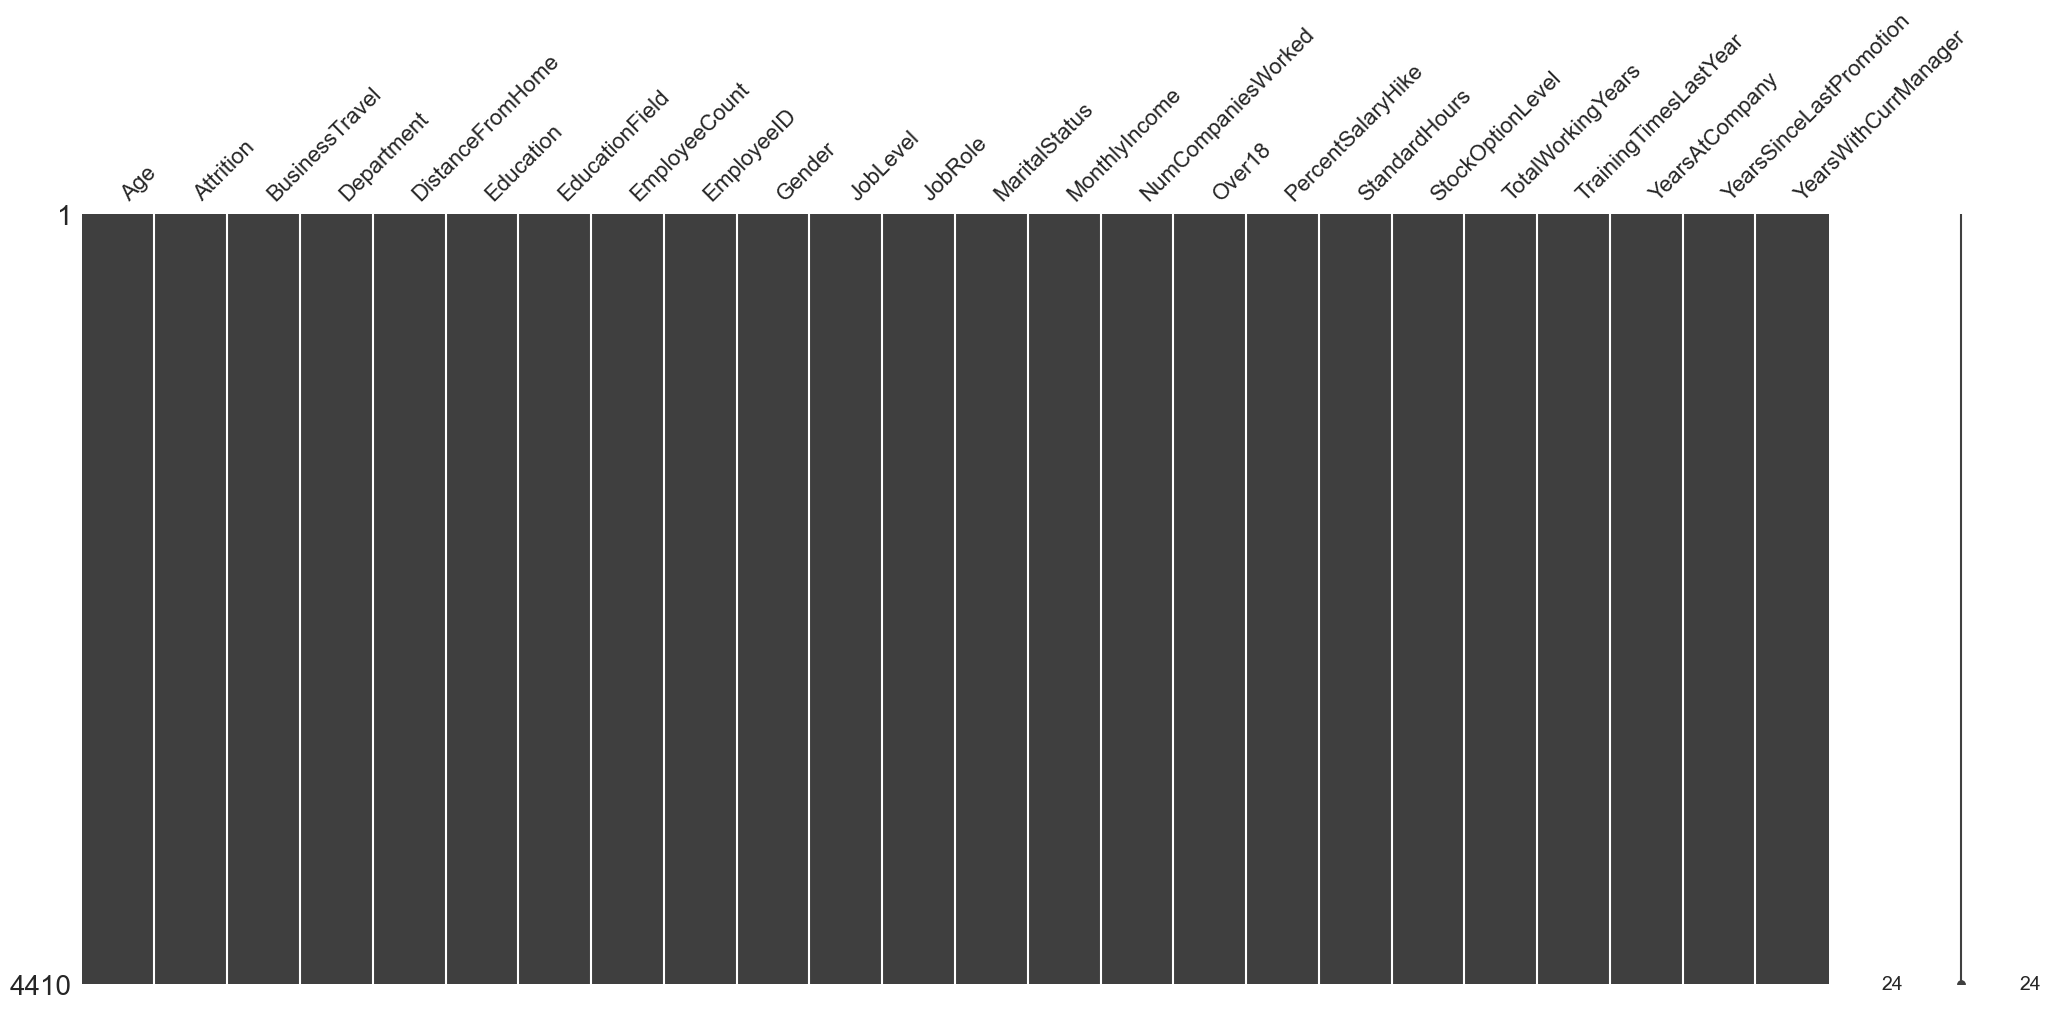

Valeurs manquantes dans Employee Data :
----------------------------
EmployeeID                 0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
dtype: int64

Valeurs manquantes dans Employee Data :
----------------------------


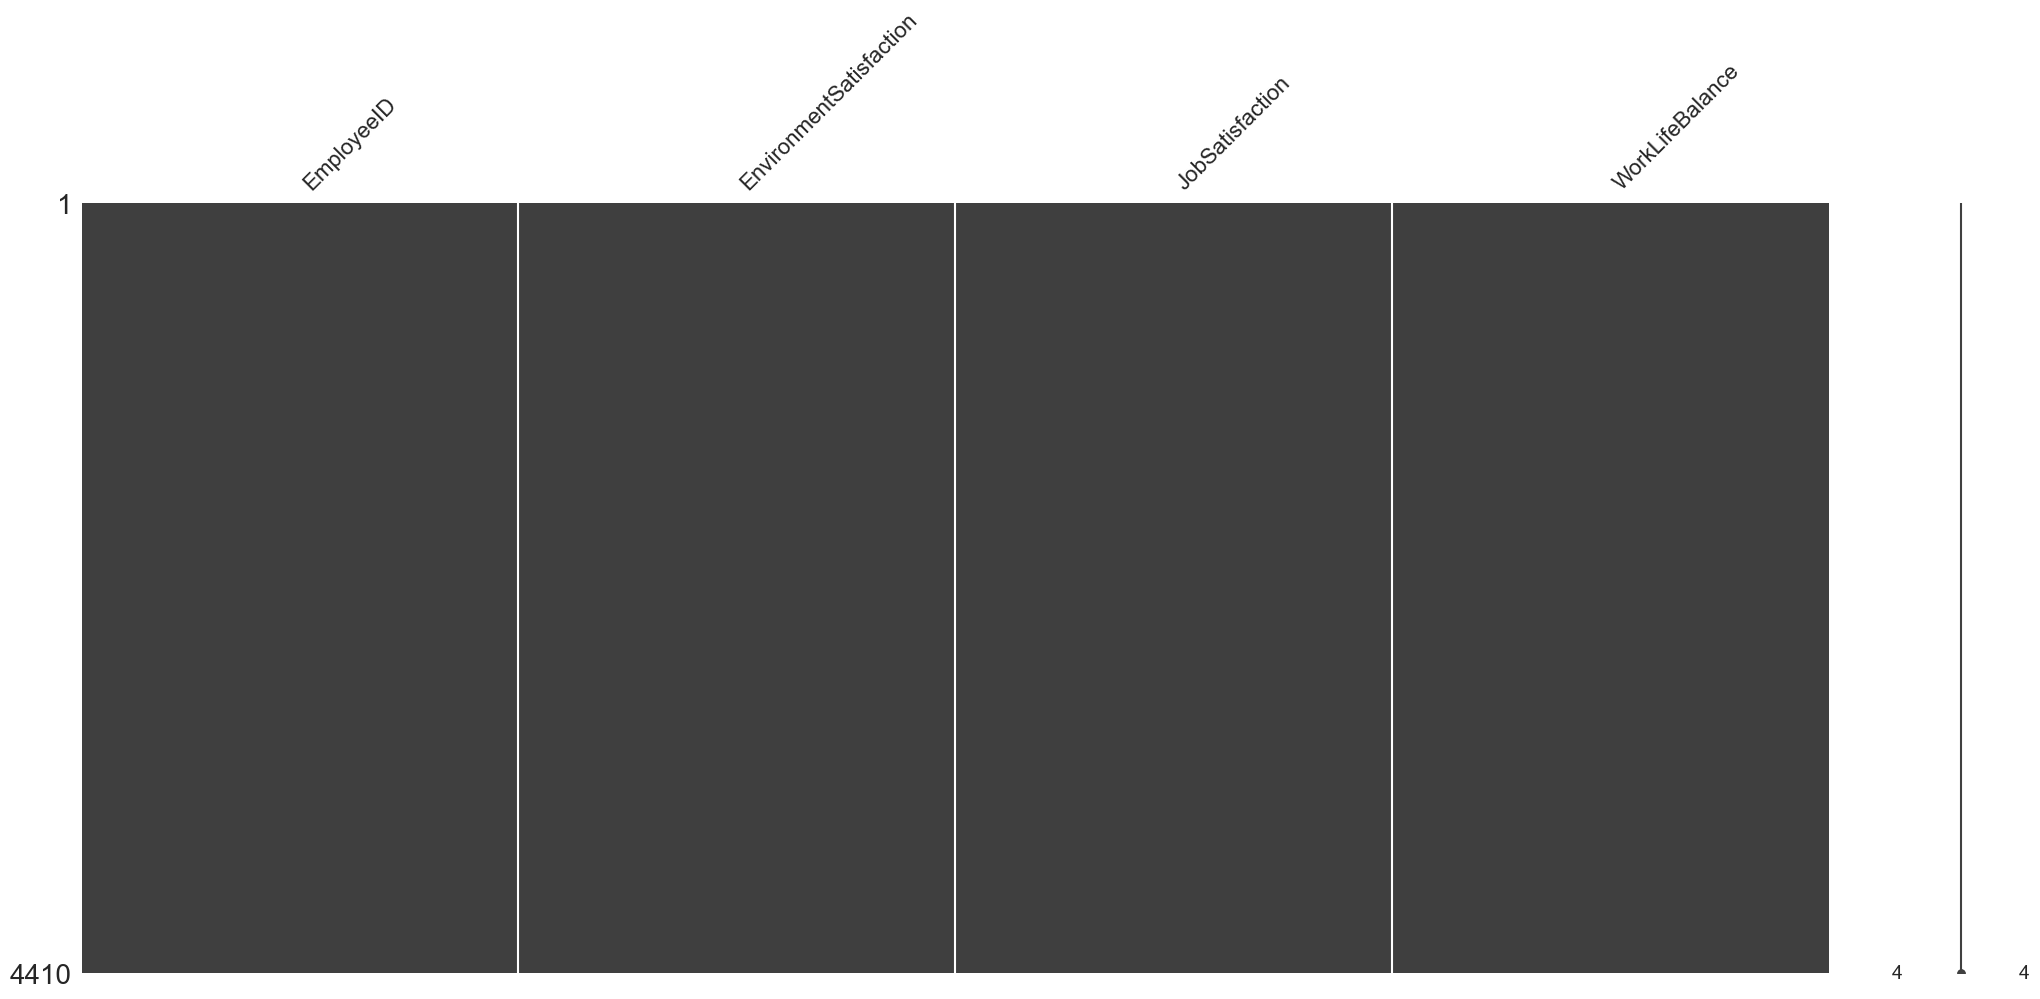

In [78]:
# Vérification des valeurs manquantes dans general_df
textual_missing_data(general_df,"General Data")
visual_missing_data(general_df,"General Data")
# Vérification des valeurs manquantes dans employee_df
textual_missing_data(employee_df,"Employee Data")
visual_missing_data(employee_df,"Employee Data")

## **5. Analyse exploratoire des données**

### **5.1 Analyse Descriptive**

In [79]:
display_describe(general_df)
display_describe(manager_df)
display_describe(employee_df)

               Age  DistanceFromHome    Education  EmployeeCount   EmployeeID  \
count  4410.000000       4410.000000  4410.000000         4410.0  4410.000000   
mean     36.923810          9.192517     2.912925            1.0  2205.500000   
std       9.133301          8.105026     1.023933            0.0  1273.201673   
min      18.000000          1.000000     1.000000            1.0     1.000000   
25%      30.000000          2.000000     2.000000            1.0  1103.250000   
50%      36.000000          7.000000     3.000000            1.0  2205.500000   
75%      43.000000         14.000000     4.000000            1.0  3307.750000   
max      60.000000         29.000000     5.000000            1.0  4410.000000   

          JobLevel  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count  4410.000000    4410.000000         4410.000000        4410.000000   
mean      2.063946   65029.312925            2.691837          15.209524   
std       1.106689   47068.888559         

**Répartition des différentes valeurs**

In [80]:
describe_values_columns(general_df, "MaritalStatus")
describe_values_columns(general_df, "JobRole")
describe_values_columns(general_df, "Attrition")

MaritalStatus
Married     2019
Single      1410
Divorced     981
Name: count, dtype: int64 
--------------------------------------------

JobRole
Sales Executive              978
Research Scientist           876
Laboratory Technician        777
Manufacturing Director       435
Healthcare Representative    393
Manager                      306
Sales Representative         249
Research Director            240
Human Resources              156
Name: count, dtype: int64 
--------------------------------------------

Attrition
No     3699
Yes     711
Name: count, dtype: int64 
--------------------------------------------



In [81]:
# Séparer le DataFrame selon Attrition pour savoir si la data est équilibrée
df_yes = general_df[general_df['Attrition']=='Yes']
df_no = general_df[general_df['Attrition']=='No']

print("MonthlyIncome - Attrition=Yes", "\n--------------------------------------------\n")
describe_columns(df_yes, "MonthlyIncome")
print("\nMonthlyIncome - Attrition=No", "\n--------------------------------------------\n")
describe_columns(df_no, "MonthlyIncome")


MonthlyIncome - Attrition=Yes 
--------------------------------------------

count       711.000000
mean      61682.616034
std       44792.067695
min       10090.000000
25%       28440.000000
50%       49080.000000
75%       71040.000000
max      198590.000000
Name: MonthlyIncome, dtype: float64

MonthlyIncome - Attrition=No 
--------------------------------------------

count      3699.000000
mean      65672.595296
std       47472.814021
min       10510.000000
25%       29360.000000
50%       49300.000000
75%       86060.000000
max      199990.000000
Name: MonthlyIncome, dtype: float64


##  6. Analyse Univariée

### **6.1 Analyse univariée des variables numériques**

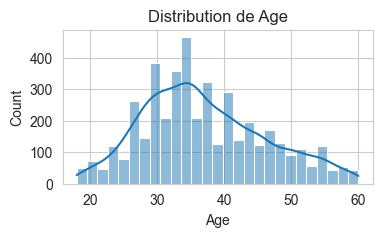

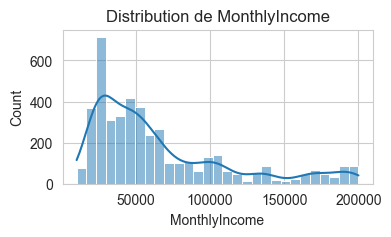

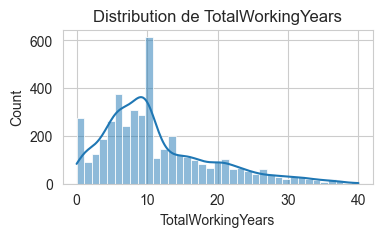

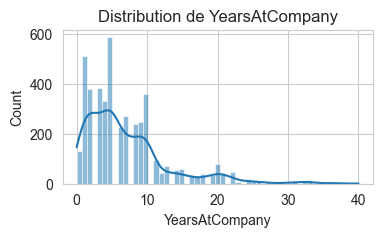

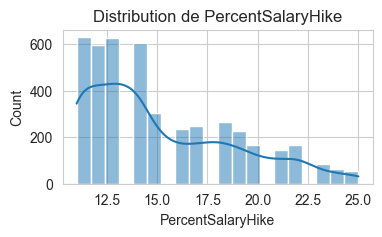

In [82]:
df = merge_dataframe(general_df, manager_df, "EmployeeID")
df = merge_dataframe(df, employee_df, "EmployeeID")

numeric_cols = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'PercentSalaryHike']
for col in numeric_cols:
    display_graphics_numeral_column(df, col)

**Distribution de l’Age :** La répartition de l’âge est approximativement symétrique, avec un pic autour de la trentaine, suggérant une population d’employés relativement jeune et homogène.

**Distribution de MonthlyIncome :** Le revenu mensuel est fortement asymétrique vers la droite, indiquant que la majorité des employés gagnent moins, tandis qu’une minorité perçoit des revenus très élevés.

**Distribution de TotalWorkingYears :** Le nombre total d’années d’expérience est concentré sur les premières années, montrant une main-d’œuvre globalement jeune ou peu expérimentée.

**Distribution de YearsAtCompany :** Les années passées dans l’entreprise sont majoritairement faibles, indiquant une ancienneté souvent faible et potentiellement un turnover élevé.

**Distribution de PercentSalaryHike :** Les augmentations de salaire percentuelles sont majoritairement regroupées entre 11% et 15%, suggérant une politique d’augmentation relativement uniforme

### **6.2 Analyse univariée des variables objet**

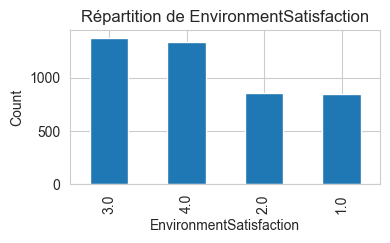

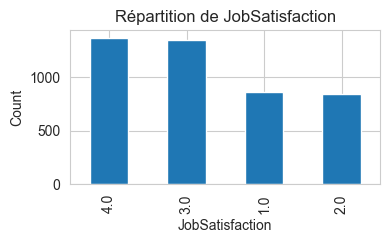

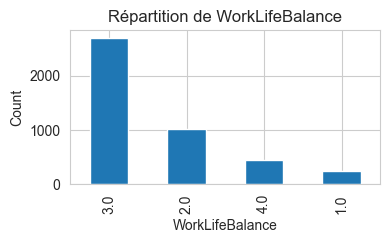

In [83]:
# Satisfaction (EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance) sont souvent entre 1 et 4
# Distribution univariée (catégoriel ordinal)
ordinal_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for col in ordinal_cols:
    display_graphics_cat_column(df, col)

**Répartition de EnvironmentSatisfaction :** Les niveaux 3 et 4 (élevé/très élevé) sont plus fréquents, indiquant une bonne satisfaction de l’environnement de travail pour la majorité.

**Répartition de JobSatisfaction :** Les niveaux de satisfaction au travail sont élevés (3 et 4) pour la plupart, signifiant un bon ressenti professionnel global.

**Répartition de WorkLifeBalance :** Le niveau 3 (très satisfaisant) domine, illustrant une perception globalement positive de l’équilibre entre vie professionnelle et personnelle.

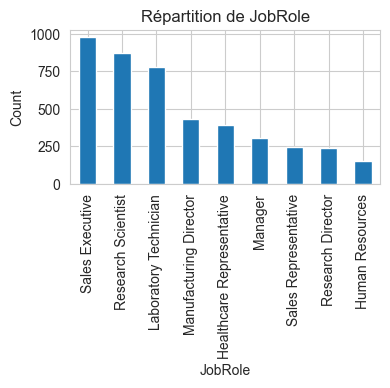

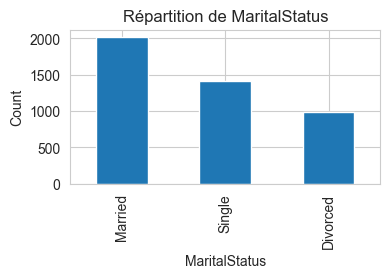

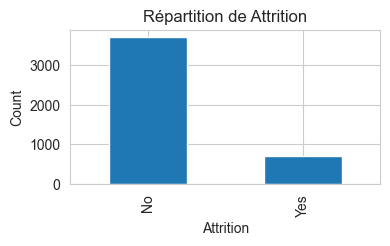

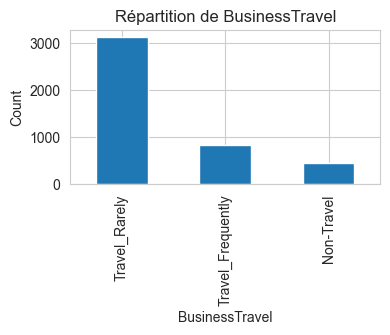

In [84]:
# Pour les variables catégorielles (ex: JobRole, MaritalStatus)
cat_cols = ['JobRole', 'MaritalStatus', 'Attrition', 'BusinessTravel']
for col in cat_cols:
    display_graphics_cat_column(df, col)

**Répartition de JobRole :** Certains rôles, comme « Sales Executive » et « Research Scientist », dominent, suggérant une structure d’effectifs où certaines fonctions sont plus représentées.

**Répartition de MaritalStatus :** Les employés mariés sont les plus nombreux, ce qui pourrait influencer certaines préférences (équilibre vie pro/vie perso, stabilité).

**Répartition de l'Attrition :** Le nombre d’employés restants est nettement supérieur aux partants, mais la proportion de départs est suffisante pour justifier une analyse des causes.

**Répartition de BusinessTravel :** La plupart des employés voyagent rarement, laissant penser que la mobilité fréquente n’est pas la norme.

## 7. Analyse Bivariée

### **7.1 Relation entre variables numériques**

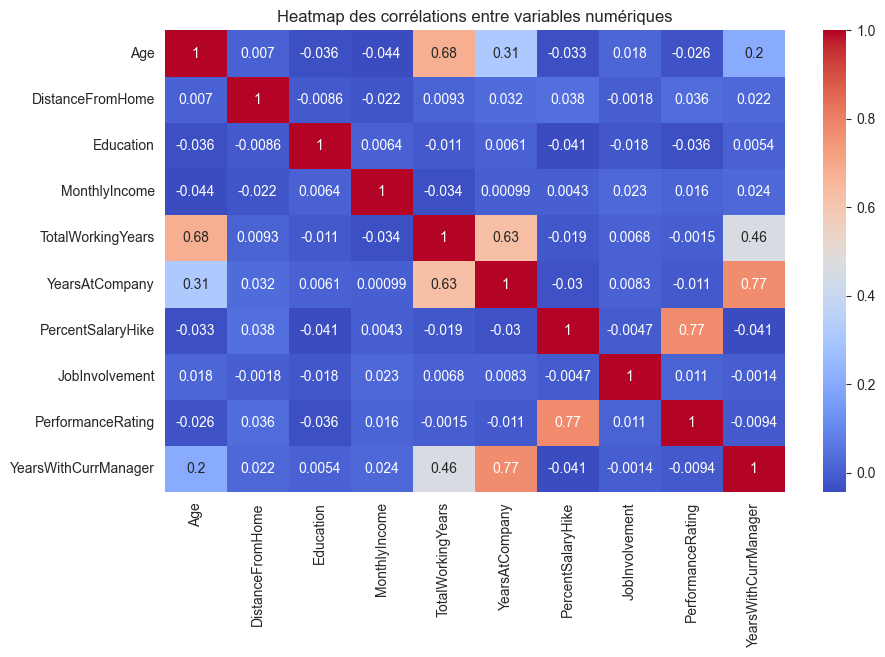

In [85]:
num_vars = ['Age', 'DistanceFromHome' , 'Education' , 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'PercentSalaryHike', 'JobInvolvement', 'PerformanceRating', 'YearsWithCurrManager']
display_heatmap_numeric_values(df,num_vars)

Heatmap des corrélations : L’âge et l’ancienneté totale (TotalWorkingYears) sont fortement corrélés, ce qui est logique, tandis que d’autres corrélations sont plus faibles, suggérant peu de relations linéaires marquées entre les variables numériques.

C:\Users\justi\PycharmProjects\GesEmpAI\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 72.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\justi\PycharmProjects\GesEmpAI\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\justi\PycharmProjects\GesEmpAI\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 68.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\justi\PycharmProjects\GesEmpAI\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


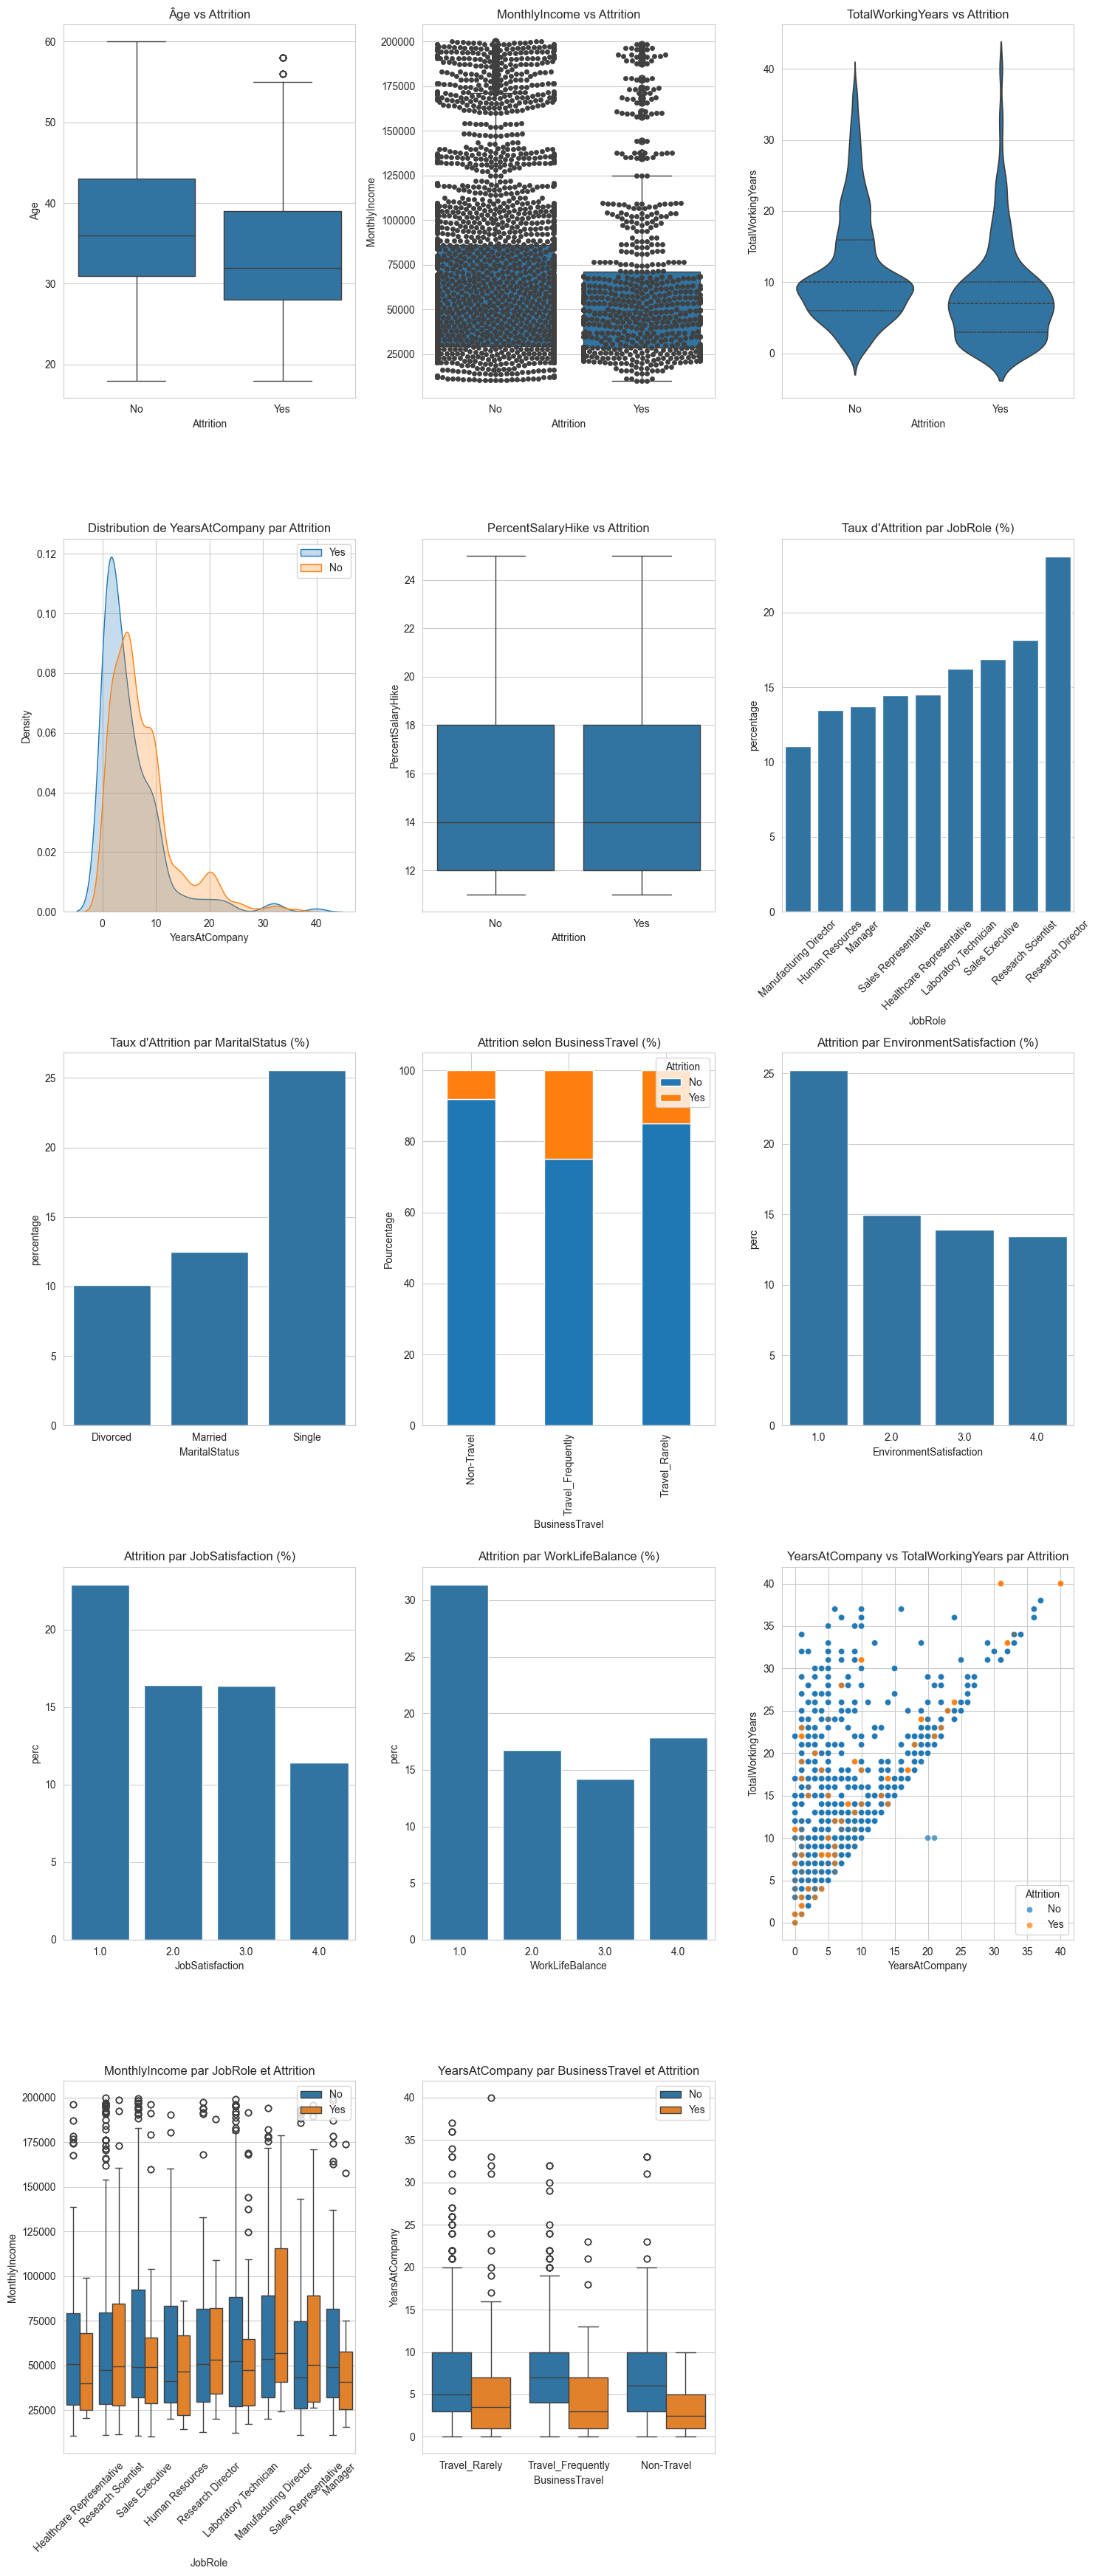

In [86]:
sns.set_style("whitegrid")

# Création de la figure et d'une grille d'axes 7x2
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 35))
axes = axes.flatten()  # Pour plus de simplicité, on a une liste d'axes

# 1. Age vs. Attrition : Boxplot
sns.boxplot(x='Attrition', y='Age', data=df, ax=axes[0])
axes[0].set_title("Âge vs Attrition")

# 2. MonthlyIncome vs. Attrition : Boxplot + swarmplot
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df, ax=axes[1])
sns.swarmplot(x='Attrition', y='MonthlyIncome', data=df, color=".25", ax=axes[1])
axes[1].set_title("MonthlyIncome vs Attrition")

# 3. TotalWorkingYears vs. Attrition : Violin plot
sns.violinplot(x='Attrition', y='TotalWorkingYears', data=df, inner='quartile', ax=axes[2])
axes[2].set_title("TotalWorkingYears vs Attrition")

# 4. YearsAtCompany vs. Attrition : KDE plot
df_yes = df[df['Attrition'] == 'Yes']
df_no = df[df['Attrition'] == 'No']
sns.kdeplot(df_yes['YearsAtCompany'], shade=True, label='Yes', ax=axes[3])
sns.kdeplot(df_no['YearsAtCompany'], shade=True, label='No', ax=axes[3])
axes[3].set_title("Distribution de YearsAtCompany par Attrition")
axes[3].legend()

# 5. PercentSalaryHike vs. Attrition : Boxplot
sns.boxplot(x='Attrition', y='PercentSalaryHike', data=df, ax=axes[4])
axes[4].set_title("PercentSalaryHike vs Attrition")

# 6. JobRole vs. Attrition : Taux d'attrition par rôle
job_role_attrition = df.groupby('JobRole')['Attrition'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
job_role_yes = job_role_attrition[job_role_attrition['Attrition'] == 'Yes']
sns.barplot(x='JobRole', y='percentage', data=job_role_yes, order=job_role_yes.sort_values('percentage')['JobRole'], ax=axes[5])
axes[5].set_title("Taux d'Attrition par JobRole (%)")
axes[5].tick_params(axis='x', rotation=45)

# 7. MaritalStatus vs. Attrition
marital_attrition = df.groupby('MaritalStatus')['Attrition'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
marital_yes = marital_attrition[marital_attrition['Attrition'] == 'Yes']
sns.barplot(x='MaritalStatus', y='percentage', data=marital_yes, order=marital_yes.sort_values('percentage')['MaritalStatus'], ax=axes[6])
axes[6].set_title("Taux d'Attrition par MaritalStatus (%)")

# 8. BusinessTravel vs. Attrition : Répartition empilée
bt_ct = pd.crosstab(df['BusinessTravel'], df['Attrition'], normalize='index') * 100
bt_ct.plot(kind='bar', stacked=True, ax=axes[7])
axes[7].set_title("Attrition selon BusinessTravel (%)")
axes[7].set_ylabel("Pourcentage")

# 9. EnvironmentSatisfaction vs. Attrition
env_attrition = df.groupby('EnvironmentSatisfaction')['Attrition'].value_counts(normalize=True).mul(100).rename('perc').reset_index()
env_yes = env_attrition[env_attrition['Attrition'] == 'Yes']
sns.barplot(x='EnvironmentSatisfaction', y='perc', data=env_yes, ax=axes[8])
axes[8].set_title("Attrition par EnvironmentSatisfaction (%)")

# 10. JobSatisfaction vs. Attrition
job_sat_attrition = df.groupby('JobSatisfaction')['Attrition'].value_counts(normalize=True).mul(100).rename('perc').reset_index()
job_sat_yes = job_sat_attrition[job_sat_attrition['Attrition'] == 'Yes']
sns.barplot(x='JobSatisfaction', y='perc', data=job_sat_yes, ax=axes[9])
axes[9].set_title("Attrition par JobSatisfaction (%)")

# 11. WorkLifeBalance vs. Attrition
wlb_attrition = df.groupby('WorkLifeBalance')['Attrition'].value_counts(normalize=True).mul(100).rename('perc').reset_index()
wlb_yes = wlb_attrition[wlb_attrition['Attrition'] == 'Yes']
sns.barplot(x='WorkLifeBalance', y='perc', data=wlb_yes, ax=axes[10])
axes[10].set_title("Attrition par WorkLifeBalance (%)")

# 12. Interaction YearsAtCompany et TotalWorkingYears
sns.scatterplot(x='YearsAtCompany', y='TotalWorkingYears', hue='Attrition', data=df, alpha=0.7, ax=axes[11])
axes[11].set_title("YearsAtCompany vs TotalWorkingYears par Attrition")

# 13. Interaction JobRole - MonthlyIncome vs. Attrition
sns.boxplot(x='JobRole', y='MonthlyIncome', hue='Attrition', data=df, ax=axes[12])
axes[12].set_title("MonthlyIncome par JobRole et Attrition")
axes[12].tick_params(axis='x', rotation=45)
axes[12].legend(loc='upper right')

# 14. Interaction BusinessTravel - YearsAtCompany vs. Attrition
sns.boxplot(x='BusinessTravel', y='YearsAtCompany', hue='Attrition', data=df, ax=axes[13])
axes[13].set_title("YearsAtCompany par BusinessTravel et Attrition")
axes[13].legend(loc='upper right')

# Supprimer les axes inutilisés
for ax in axes:
    if not ax.has_data():
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

- Âge vs Attrition : Les employés partants sont en moyenne plus jeunes, indiquant une tendance au départ précoce.

- MonthlyIncome vs Attrition : Les salariés qui quittent ont souvent un revenu mensuel plus bas, suggérant une influence du salaire sur le départ.

- TotalWorkingYears vs Attrition : Les employés partants ont globalement moins d’expérience professionnelle, pointant vers une rétention plus difficile des moins expérimentés.

- YearsAtCompany par Attrition : La faible ancienneté chez ceux qui partent indique un départ précoce après une courte période dans l’entreprise.

- PercentSalaryHike vs Attrition : Les hausses salariales ne semblent pas différencier les partants des restants, suggérant un impact limité de ce facteur.

- Taux d’Attrition par JobRole : Certains postes présentent des taux d’attrition plus élevés, signalant des problématiques propres à certaines fonctions.

- Taux d’Attrition par MaritalStatus : Les célibataires partent plus souvent, laissant penser que le statut marital peut influencer la décision de quitter.

- Attrition selon BusinessTravel : Les employés voyageant fréquemment quittent davantage, suggérant que la mobilité professionnelle affecte la rétention.

- Attrition par EnvironmentSatisfaction : Un niveau faible de satisfaction environnementale se traduit par un taux de départ plus important.

- Attrition par JobSatisfaction : Moins la satisfaction au travail est élevée, plus le risque de départ augmente.

- Attrition par WorkLifeBalance : Un mauvais équilibre vie-travail est associé à une plus forte probabilité de quitter l’entreprise.

- YearsAtCompany vs TotalWorkingYears par Attrition : Malgré une expérience totale variable, les faibles anciennetés internes sont corrélées à plus de départs.

- MonthlyIncome par JobRole et Attrition : Dans la plupart des postes, les employés à salaire inférieur quittent plus souvent, renforçant l’impact du revenu sur l’attrition.
- YearsAtCompany par BusinessTravel et Attrition : Les employés voyageant fréquemment et ayant une faible ancienneté sont particulièrement enclins à partir rapidement.



In [87]:
print("\n--------------------------------------------------------\nINFO (AVANT)\n--------------------------------------------------------")

print(df.info())

# Supposons qu’on a déjà supprimé les colonnes inutiles
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# Identification des variables
# Catégorielles (type object) - exemple
cat_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'Attrition']

# La variable cible (Attrition)
# Convertir l’Attrition en binaire
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

# Variables numériques
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ['Attrition']]

# Optionnel : Si certaines variables catégorielles sont ordinales, les laisser telles quelles
# Ex : Education déjà en int (1 à 5) pourrait être considéré ordinal
# Si Education est un int et représente un niveau, on peut le laisser dans num_cols ou le transformer séparément.
# Supposons qu’ici Education est déjà un nombre (1 à 5), on le laisse dans num_cols vu que c’est ordinal.

# Mise en place de la pipeline de transformations

# One-Hot Encoding pour les variables catégorielles nominales
# Standardisation pour les variables numériques

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),            # standardisation des numériques
        ('cat', categorical_transformer, cat_cols)         # one-hot encoding des catégorielles
    ],
    remainder='passthrough'  # si d'autres colonnes existent, les laisser telles quelles
)

# Appliquer la transformation
df_transformed = preprocessor.fit_transform(df)

# df_transformed est un numpy array. Si vous souhaitez un DataFrame final :
# On récupère les noms de colonnes des features après transformation
# Pour les colonnes numériques, les noms restent les mêmes
num_feature_names = num_cols

# Pour les colonnes catégorielles encodées, récupérer les nouvelles colonnes encodées
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

all_feature_names = list(num_feature_names) + list(cat_feature_names) + ['Attrition'] # Inclure la cible si vous souhaitez la garder dans le même dataset, sinon la retirer avant fit_transform

# Si vous souhaitez le DataFrame final (sans la cible qui est dans df), séparez la cible avant:
y = df['Attrition']
X = df.drop('Attrition', axis=1)
X_transformed = preprocessor.fit_transform(X)

final_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed,
                        columns=list(num_feature_names) + list(cat_feature_names))

# Ajouter la variable cible séparément
final_df['Attrition'] = y.values

print("\n--------------------------------------------------------\nINFO\n--------------------------------------------------------")
print(final_df.info())


--------------------------------------------------------
INFO (AVANT)
--------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  Mari

## Correction du déséquilibre

Le déséquilibre des classes est un problème fréquent dans les ensembles de données utilisés pour le machine learning. Cela se produit lorsqu'une ou plusieurs catégories dans les données d'entraînement sont sous-représentées par rapport aux autres. Dans notre cas, l'hyperparamètre `Attrition` est une valeur binaire où la catégorie `oui` est sous représenté.

In [88]:
# Supposons que 'df' est votre DataFrame et 'attrition' est la colonne cible
X = final_df.drop('Attrition', axis=1)
y = final_df['Attrition']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_res, y_train_res = apply_oversampling(X_train,y_train)

# Vérifier la distribution des classes après rééchantillonnage
print("Distribution des classes avant rééchantillonnage :")
print(y_train.value_counts())
print("\nDistribution des classes après rééchantillonnage :")
print(y_train_res.value_counts())

Distribution des classes avant rééchantillonnage :
Attrition
0    2958
1     570
Name: count, dtype: int64

Distribution des classes après rééchantillonnage :
Attrition
0    2958
1    2958
Name: count, dtype: int64


1. Distribution avant rééchantillonnage

Catégorie `0` : 83,85 %

Catégorie `1` : 16,15 %

Déséquilibre initial :
    La classe 0 est nettement surreprésentée par rapport à la classe 1, avec un ratio d'environ 5,2:1. Cela signifie que les modèles d'apprentissage automatique auraient été biaisés en faveur de la classe 0, risquant d'ignorer les occurrences de la classe 1 (la classe minoritaire).

2. Distribution après rééchantillonnage

Catégorie `0` : 50 %

Catégorie `1` : 50 %

Correction du déséquilibre :
    Le rééchantillonnage a équilibré parfaitement les deux classes, avec une distribution uniforme. Cela garantit que le modèle traitera les deux classes de manière équitable pendant l'entraînement.

## Prise de décision éthique

Pour respecter les différentes normes indiquées dans la charte éthique, nous devons retirer la colonne contenant les informations de genre, âge et le statut matrimonial.

In [92]:
#Suppression de la colonne Gender
X_train_res = X_train_res.drop('Gender_Male', axis=1, errors='ignore')
X_train_res = X_train_res.drop('Gender_Female', axis=1, errors='ignore')

#Suppression de la colonne Age
X_train_res = X_train_res.drop('Age', axis=1, errors='ignore')

#Suppression de la colonne MaritalStatus
X_train_res = X_train_res.drop('MaritalStatus_Married', axis=1, errors='ignore')
X_train_res = X_train_res.drop('MaritalStatus_Single', axis=1, errors='ignore')

visualize_structure(X_train_res,"Données pour l'apprentissage")

"['Gender_Male'] not found in axis"
"['Gender_Female'] not found in axis"
"['Age'] not found in axis"
"['MaritalStatus_Married'] not found in axis"
"['MaritalStatus_Single'] not found in axis"
-------------------------------------------
 Données pour l'apprentissage 
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5916 entries, 0 to 5915
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DistanceFromHome                   5916 non-null   float64
 1   Education                          5916 non-null   float64
 2   JobLevel                           5916 non-null   float64
 3   MonthlyIncome                      5916 non-null   float64
 4   NumCompaniesWorked                 5916 non-null   float64
 5   PercentSalaryHike                  5916 non-null   float64
 6   StockOptionLevel                   5916 non-null   float64
 7   

## Étude comparative des différents modèles

### **Liste des différents modèles observés**

- Régression logistique
- Arbre de décision
- Kernel SVM
- (Réseau neuronal)